In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from sam2.build_sam import build_sam2_video_predictor

CHECKPOINT = "../checkpoints/sam2_hiera_small.pt"
CONFIG = "sam2_hiera_s.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

D:\SAM2\segment-anything-2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [5]:
import supervision as sv
import os
os.makedirs(name="video_frames",exist_ok=True)
frames_generator = sv.get_video_frames_generator("1.mp4")
sink = sv.ImageSink(
    target_dir_path="video_frames",
    image_name_pattern="{:05d}.jpeg")

with sink:
    for frame in frames_generator:
        sink.save_image(frame)

In [4]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
inference_state = sam2_model.init_state("video_frames")

frame loading (JPEG): 100%|██████████| 192/192 [00:08<00:00, 21.72it/s]
D:\SAM2\segment-anything-2\sam2\modeling\backbones\hieradet.py:72: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


In [6]:
import numpy as np

points = np.array([[130, 100],[320,35],[490,115]], dtype=np.float32)
labels = np.array([1,1,1])
frame_idx = 0
tracker_id = 1

_, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id,
    points=points,
    labels=labels,
)

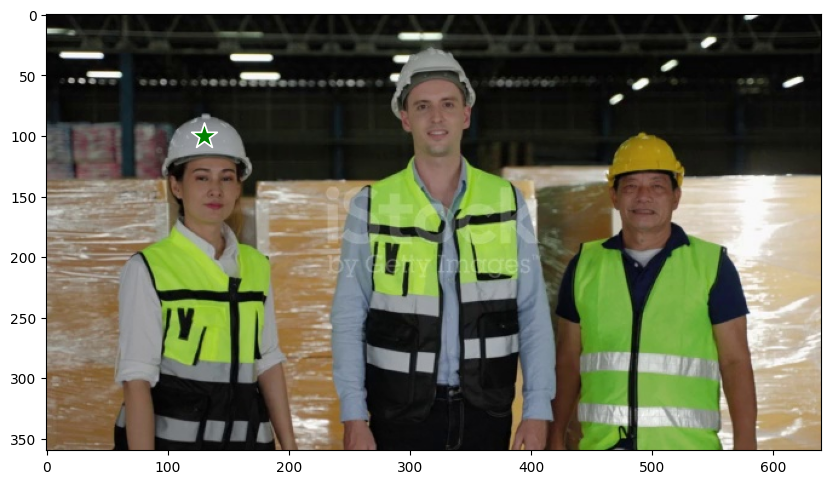

In [6]:
from PIL import Image
image = Image.open("video_frames/00000.jpeg")
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
points = np.array([[130, 100]], dtype=np.float32)
show_points(points,labels, plt.gca())
plt.axis('on')
plt.show()  

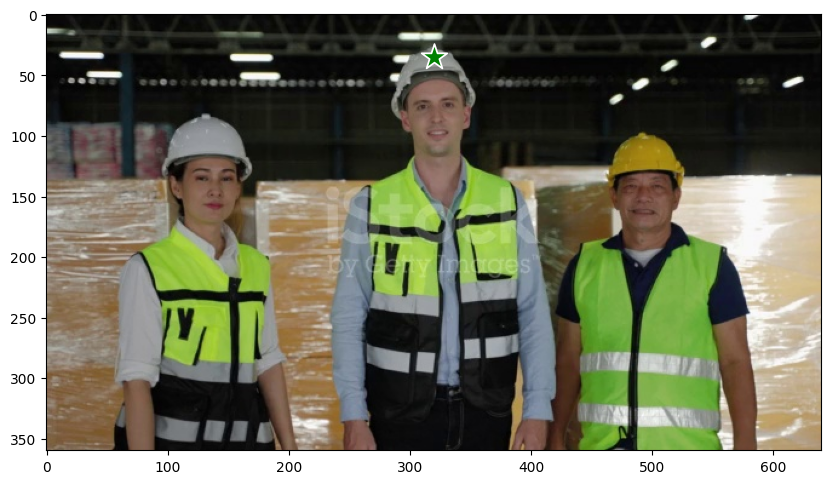

In [17]:
from PIL import Image
image = Image.open("video_frames/00000.jpeg")
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
points = np.array([[320, 35]], dtype=np.float32)
show_points(points,labels, plt.gca())
plt.axis('on')
plt.show()  

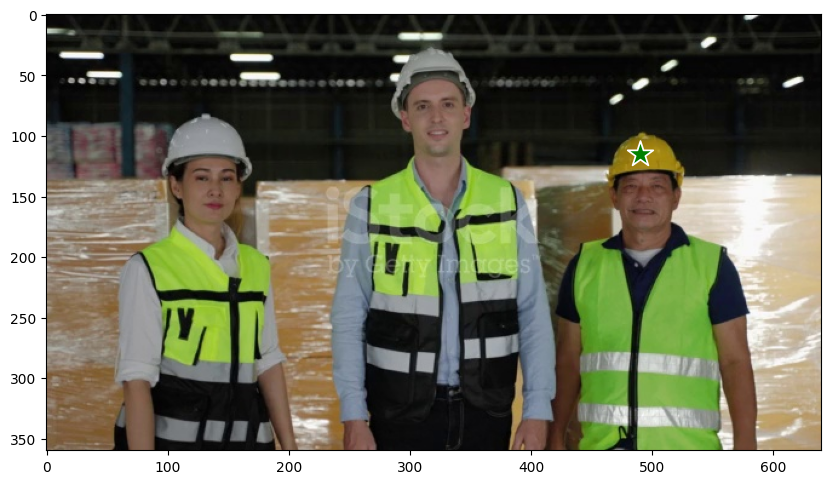

In [22]:
from PIL import Image
image = Image.open("video_frames/00000.jpeg")
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
points = np.array([[490, 115]], dtype=np.float32)
show_points(points,labels, plt.gca())
plt.axis('on')
plt.show()  

In [7]:
import cv2
import supervision as sv

colors = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    color_lookup=sv.ColorLookup.TRACK)

video_info = sv.VideoInfo.from_video_path("1.mp4")
frames_paths = sorted(sv.list_files_with_extensions(
    directory="video_frames", 
    extensions=["jpeg"]))

with sv.VideoSink("output_video.mp4", video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame = cv2.imread(frames_paths[frame_idx])
        masks = (mask_logits > 0.0).cpu().numpy()
        N, X, H, W = masks.shape
        masks = masks.reshape(N * X, H, W)
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=np.array(object_ids)
        )
        frame = mask_annotator.annotate(frame, detections)
        sink.write_frame(frame)

propagate in video: 100%|██████████| 192/192 [01:52<00:00,  1.71it/s]
